# Исследование посетителей супермаркета

## Цель
Провести комплексный многоаспектный анализ данных о посетителях супермаркета с целью выявления скрытых закономерностей в демографических характеристиках, уровне дохода и покупательском поведении. Исследование включает сегментацию клиентов, изучение взаимосвязей между ключевыми переменными (возраст, доход, затраты) и разработку прогностических моделей для поддержки решений в маркетинге и развития клиентской базы.

## Вопросы
1. На какие сегменты можно разделить клиентов супермаркета?
2. Какие зависимости существуют между возрастом, уровнем дохода и тратами клиентов?
3. Как влияет пол на распределение доходов и покупательских оценок?
4. Можно ли создать надёжную прогностическую модель для оценки Spending Score на основе возраста, уровня дохода и пола? Какие факторы являются наиболее значимыми?
5. Какие аномалии и выбросы присутствуют в данных, и как они могут влиять на результаты анализа?

## Описание
Для проведения исследования был взят следующий набор данных:
https://www.kaggle.com/datasets/vjchoudhary7/customer-segmentation-tutorial-in-python

Есть супермаркет и с помощью членских карт мы получаем некоторые базовые данные о своих клиентах, такие как идентификатор клиента, возраст, пол, годовой доход и рейтинг расходов.
Рейтинг расходов — это показатель, который вы присваиваете клиенту на основе заданных вами параметров, таких как поведение клиента и данные о покупках.

## План
1. Обзор данных
2. Визуализация данных
3. Вопрос 1: На какие сегменты можно разделить клиентов супермаркета?

# Обзор данных
Проведём обзор данных с целью понять их структуру и проверить наличие ошибок

### Импорт библиотек

Определим также функцию для диагностики данных в dataframe

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px

df = pd.read_csv('data\mall_customers.csv', sep = ',')

# функция для диагностики df
def df_diagnostics(df):
    # Собираем основные характеристики столбцов
    diag = pd.DataFrame({'dtypes': df.dtypes, 'count': df.count(), 'unique': df.nunique(),
                         'NaN count': df.isnull().sum(), 'NaN percentage': df.isnull().sum() / df.shape[0]})
    
    # Словарь описывающий, какую функцию применить для каждой метрики
    metrics = {'mean': lambda s: s.mean(), 'median': lambda s: s.median(), 'std': lambda s: s.std(),
               'min':  lambda s: s.min(),  'max':    lambda s: s.max()}
    
    # Используем цикл по словарю, чтобы вычислить метрики для каждого столбца
    for metric, func in metrics.items():
        diag[metric] = [func(df[col]) if pd.api.types.is_numeric_dtype(df[col]) else np.nan 
                        for col in df.columns]
    
    # Вычисляем количество дублирующих строк в DataFrame
    duplicates_count = df.duplicated().sum()
    print("Количество дублирующих строк:", duplicates_count)
    return diag.style.background_gradient(cmap='Set3', low=0.1, high=0.01)

### Обзор таблицы

In [6]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


### Диагностика данных

In [7]:
df_diagnostics(df)

Количество дублирующих строк: 0


,dtypes,count,unique,NaN count,NaN percentage,mean,median,std,min,max
CustomerID,int64,200,200,0,0.000000,100.500000,100.500000,57.879185,1.000000,200.000000
Gender,object,200,2,0,0.000000,nan,nan,nan,nan,nan
Age,int64,200,51,0,0.000000,38.850000,36.000000,13.969007,18.000000,70.000000
Annual Income (k$),int64,200,64,0,0.000000,60.560000,61.500000,26.264721,15.000000,137.000000
Spending Score (1-100),int64,200,84,0,0.000000,50.200000,50.000000,25.823522,1.000000,99.000000


Диагностика данных в таблице показала:
- дублирующих строк нет
- имена полей корректны
- типы данных соответствуют
- все клиенты по полю `CustomerID`уникальные
- пропусков нет
- данные о возрасте клиентов по полю `Age` в диапазоне от 18 до 70
- данные о годовом доходе по полю `Annual Income (k$)` в диапазоне от 15 до 137 k$
- данные о оценке расходов по полю `Spending Score (1-100)` в диапазоне от 1 до 99

# Визуализация данных

Выполним визуализацию данных для лучшего понимания их структуры.

Выводим диаграммы распределения значений для полей `Age`, `Annual Income (k$)` и `Spending Score (1-100)`

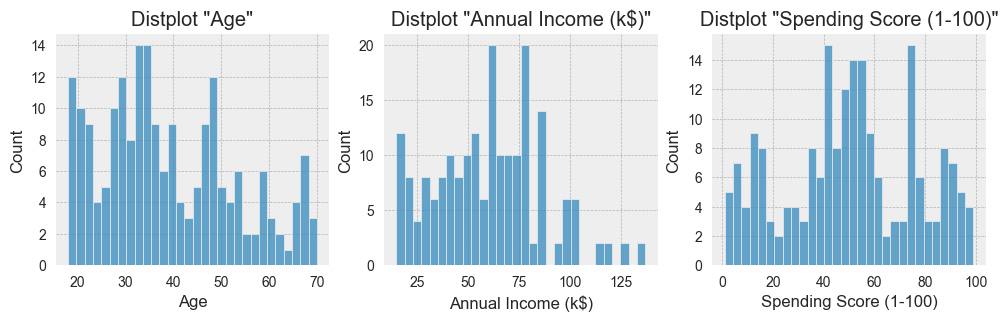

In [75]:
plt.style.use('bmh')
plt.figure(1, figsize=(12, 3))

n = 0
for x in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    sns.histplot(df[x], bins=30)
    plt.title(f'Distplot "{x}"')

plt.show()

Выводим распределение значений в поле `Gender`

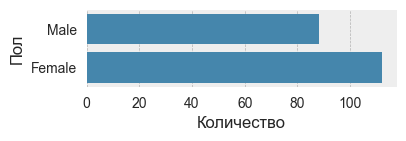

In [89]:
plt.figure(1 , figsize = (4 , 1))
sns.countplot(y = 'Gender' , data = df)
plt.xlabel('Количество'), plt.ylabel('Пол')
plt.show()

Построим графики зависимостей между возрастом, годовым доходом и показателем расходов

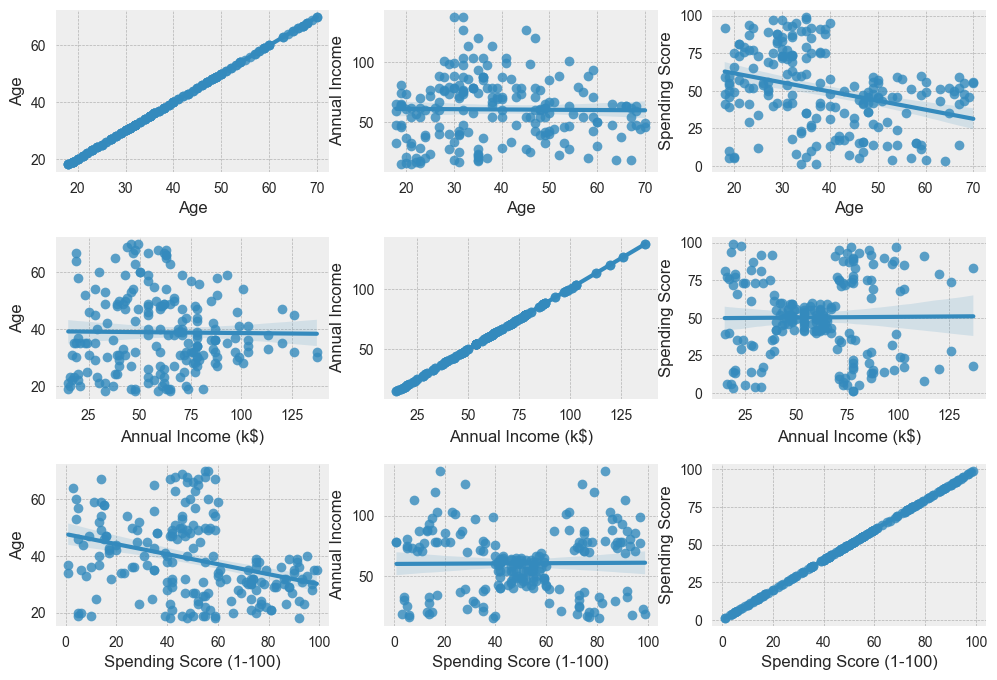

In [92]:
plt.figure(1 , figsize = (12 , 8))
n = 0 
for x in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
    for y in ['Age' , 'Annual Income (k$)' , 'Spending Score (1-100)']:
        n += 1
        plt.subplot(3 , 3 , n)
        plt.subplots_adjust(hspace = 0.4 , wspace = 0.2)
        sns.regplot(x = x , y = y , data = df)
        plt.ylabel(y.split()[0]+' '+y.split()[1] if len(y.split()) > 1 else y )
        
plt.show()

Построим график распределения годового дохода в зависимости от возраста и пола

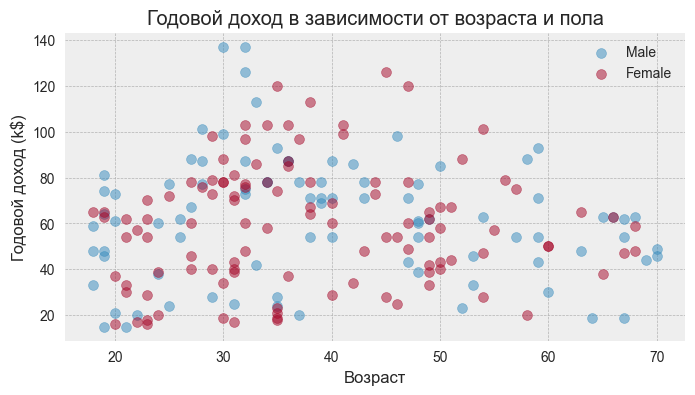

In [94]:
plt.figure(1 , figsize = (8 , 4))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Age' , y = 'Annual Income (k$)' , data = df[df['Gender'] == gender] ,
                s = 50 , alpha = 0.5 , label = gender)
plt.xlabel('Возраст'), plt.ylabel('Годовой доход (k$)')
plt.title('Годовой доход в зависимости от возраста и пола')
plt.legend()
plt.show()

Построим график распределения показателя расходов в зависимости от годового дохода и пола

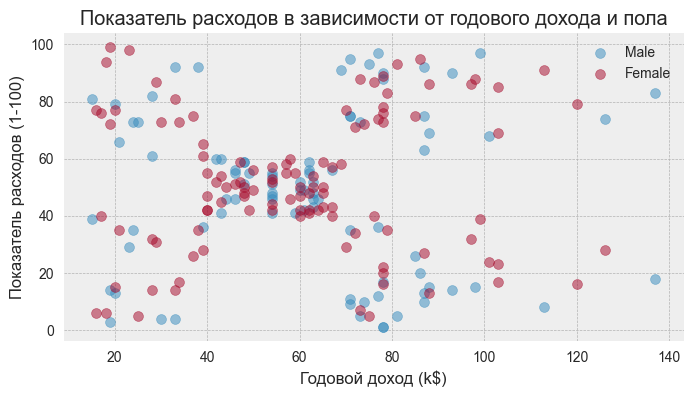

In [96]:
plt.figure(1 , figsize = (8 , 4))
for gender in ['Male' , 'Female']:
    plt.scatter(x = 'Annual Income (k$)',y = 'Spending Score (1-100)' ,
                data = df[df['Gender'] == gender] ,s = 50 , alpha = 0.5 , label = gender)
plt.xlabel('Годовой доход (k$)'), plt.ylabel('Показатель расходов (1-100)') 
plt.title('Показатель расходов в зависимости от годового дохода и пола')
plt.legend()
plt.show()

Построим скрипичные диаграммы с распределением значений по возрасту, годовому доходу и показателю расходов в зависимости от пола

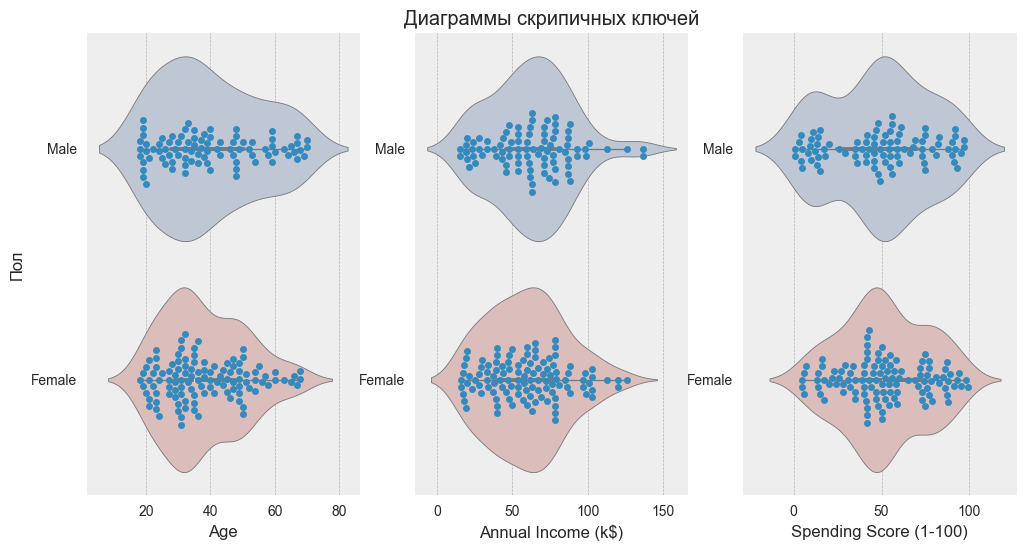

In [159]:
plt.figure(1, figsize=(12, 6))
n = 0
for cols in ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']:
    n += 1
    plt.subplot(1, 3, n)
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

    sns.violinplot(x=cols, y='Gender', data=df, hue='Gender', palette='vlag', legend=False)
    sns.swarmplot(x=cols, y='Gender', data=df)
    
    plt.ylabel('Пол' if n == 1 else '')
    plt.title('Диаграммы скрипичных ключей' if n == 2 else '')

plt.show()

# Вопрос 1: На какие сегменты можно разделить клиентов супермаркета?

Для сегментирования клиентов супермаркета выполним разделение клиентов на сегменты с помощью `кластеризации методом К-средних`

Выбор и стандартизация признаков для кластеризации

In [160]:
features = df[['Age', 'Spending Score (1-100)']].values
scaler = StandardScaler()
k1 = scaler.fit_transform(features)

Определение оптимального числа кластеров происходит путем поиска точки перегиба на графике инерции

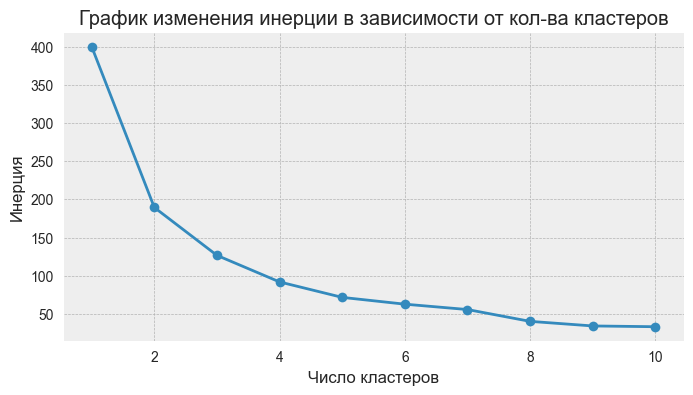

In [161]:
inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(k1)
    inertia.append(kmeans.inertia_)

# выведем график
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('График изменения инерции в зависимости от кол-ва кластеров')
plt.xlabel('Число кластеров')
plt.ylabel('Инерция')
plt.show()

Исходя из показаний графика оптимальны значения кол-ва кластеров равные 2 и 4, мы выберем 4.

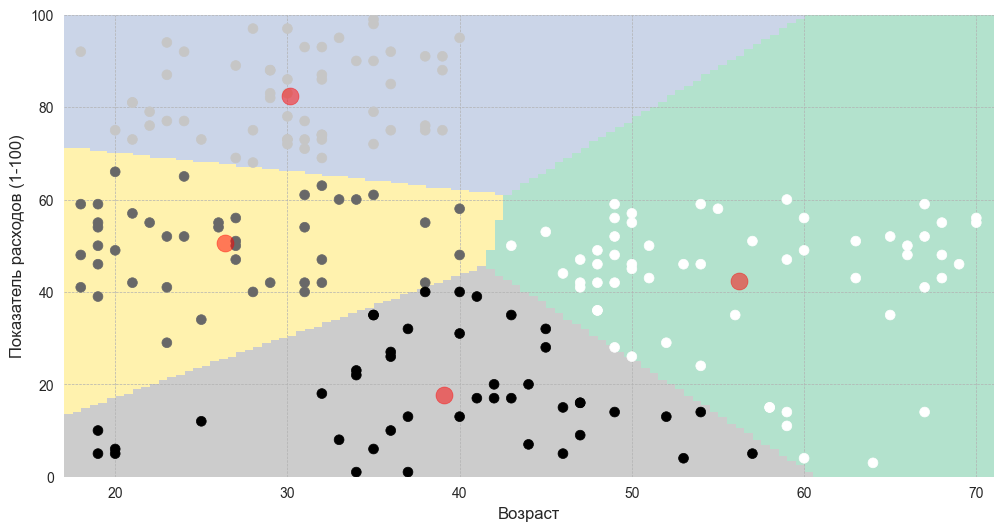

In [162]:
# Создаём модель KMeans c 4 кластерами
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(k1)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

# Переводим центроиды обратно в исходное пространство
centroids_orig = scaler.inverse_transform(centroids)

# Создаем сетку в исходном (оригинальном) пространстве
h = 0.5  # шаг сетки (подберите в зависимости от диапазонов Age и Spending Score)
x_min = df['Age'].min() - 1
x_max = df['Age'].max() + 1
y_min = df['Spending Score (1-100)'].min() - 1
y_max = df['Spending Score (1-100)'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# Преобразуем сетку в стандартизированное пространство и делаем предсказание
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_scaled = scaler.transform(grid_points)
Z = kmeans.predict(grid_points_scaled)
Z = Z.reshape(xx.shape)

# Строим график
fig, ax = plt.subplots(figsize=(12, 6))
ax.imshow(Z, interpolation='nearest',
          extent=(x_min, x_max, y_min, y_max),
          cmap=plt.cm.Pastel2,
          aspect='auto',
          origin='lower')

# Отображаем исходные данные, центроиды и границы кластеров
ax.scatter(df['Age'], df['Spending Score (1-100)'], c=labels, s=50)
ax.scatter(centroids_orig[:, 0], centroids_orig[:, 1], s=150, c='red', alpha=0.5)
ax.set_xlabel('Возраст')
ax.set_ylabel('Показатель расходов (1-100)')
plt.show()